In [1]:
from tqdm import tqdm
from utils import load_jsonl, load_jsonl_iteratively

ja_sentence_info = "./train_samples/ja_1k_ner_with_pos.jsonl"
inputs = load_jsonl(ja_sentence_info)

In [2]:
import os
import ast
from tqdm import tqdm
import re
import pandas as pd

def load_jsonl(filename):
    assert os.path.exists(filename), filename
    with open(filename, 'r', encoding="utf8") as fp:
        fixed_data = ast.literal_eval(fp.read())
    return fixed_data


iterations = []
root = "./results/per_token_loss/llm-jp-3-13b-exp1-en_jstage"
for filename in tqdm(sorted(os.listdir(root))):
    if filename.endswith(".json"):
        match = re.match("iter_([0-9]+).json", filename)
        if match:
            iter_num = int(match.group(1))
        else:
            continue
        
        filepath = os.path.join(root, filename)
        data = load_jsonl(filepath)
        data["iter"] = iter_num
        iterations.append(data)

100%|██████████| 32/32 [04:46<00:00,  8.97s/it]


In [3]:
from collections import defaultdict
from traitlets import default


def group_lang_loss(input_info, loss_per_input):
    assert len(loss_per_input['token_losses']) >= len(input_info['token'])
    i, j = 0, 0
    lang_loss = {}
    
    def add(loss, token_type):
        if token_type.startswith("Ja"):
            token_type = "Japanese"
        elif token_type.startswith("En"):
            token_type = "English"

        if token_type in lang_loss:
            lang_loss[token_type].append(loss)
        else:
            lang_loss[token_type] = [loss]
            

    record_cnt = 0    
    while i < len(loss_per_input['token_losses']):
        if loss_per_input['token_losses'][i][1] == input_info['token'][j]['token_id']:
            record_cnt += 1
            add(loss_per_input['token_losses'][i][2], input_info['token'][j]['type'])
            if len(loss_per_input['token_losses'][i]) == 3:
                loss_per_input['token_losses'][i].append(input_info['token'][j]['span'])
            i += 1
            j += 1
        else:
            i += 1
    assert record_cnt == len(input_info['token'])
    return lang_loss

def group_ner_loss(input_info, loss_per_input):
    i, j = 0, 0
    ner_loss = {'non-entity': [], 'entity': []}
    while i < len(loss_per_input['token_losses']):
        token = loss_per_input['token_losses'][i][0]
        loss = loss_per_input['token_losses'][i][2]
        if j >= len(input_info['ners']):
            ner_loss['non-entity'].append(loss)
            i += 1
            continue
        
        entity_span = input_info['ners'][j]['span']

        if len(loss_per_input['token_losses'][i]) == 3:
            i += 1
            continue
        token_span = loss_per_input['token_losses'][i][3]

        if token_span[1] <= entity_span[0] or token_span[0] >= entity_span[1]:
            ner_loss['non-entity'].append(loss)
        else:
            ner_loss['entity'].append(loss)

        if token_span[0] >= entity_span[1]:
            j += 1
        else:
            i += 1
        
    return ner_loss 

def group_pos_loss(input_info, loss_per_input):
    i, j = 0, 0
    pos_loss = defaultdict(list)
    while i < len(loss_per_input['token_losses']):
        token = loss_per_input['token_losses'][i][0]
        loss = loss_per_input['token_losses'][i][2]
        if j >= len(input_info['pos']):
            i += 1
            continue
        
        token_pos = input_info['pos'][j]['type']
        pos_span = input_info['pos'][j]['span']

        if len(loss_per_input['token_losses'][i]) == 3:
            i += 1
            continue
        token_span = loss_per_input['token_losses'][i][3]

        if token_span[1] <= pos_span[0] or token_span[0] >= pos_span[1]:
            pass
        else:
            pos_loss[token_pos].append(loss)

        if token_span[0] >= pos_span[1]:
            j += 1
        else:
            i += 1
        
    return pos_loss  


In [4]:
from collections import defaultdict


loss_inspections = {}
all_texts = [input['text'] for input in inputs]

for iteration in tqdm(iterations):
    num_iter = iteration['iter']
    loss_inspections[num_iter] = {"lang": defaultdict(list), "ner": defaultdict(list), "pos": defaultdict(list)}
    for item in iteration:
        ja_item = iteration['ja']
        aver_loss = ja_item['average_loss']
        losses = ja_item['losses']
        for text, loss_per_input in losses.items():
            assert text in all_texts, f"Text {text} not found in inputs"
            input_info = inputs[all_texts.index(text)]
            
            # Group losses by language type
            lang_loss = group_lang_loss(input_info, loss_per_input)
            for lang_type, loss_values in lang_loss.items():
                loss_inspections[num_iter]["lang"][lang_type].extend(loss_values)
            
            pos_loss = group_pos_loss(input_info, loss_per_input)
            for pos_type, pos_values in pos_loss.items():
                loss_inspections[num_iter]["pos"][pos_type].extend(pos_values)


            if "ners" not in input_info:
                input_info['ners'] = []
            ner_loss = group_ner_loss(input_info, loss_per_input)
            for ner_type, ner_values in ner_loss.items():
                loss_inspections[num_iter]["ner"][ner_type].extend(ner_values)

for iteration in loss_inspections:
    loss_inspections[iteration]["pos"] = {
        pos: losses
        for pos, losses in loss_inspections[iteration]["pos"].items()
        if len(losses) >= 10000
    }

100%|██████████| 32/32 [00:52<00:00,  1.64s/it]


/tmp/ipykernel_639343/2714347594.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=3.0)


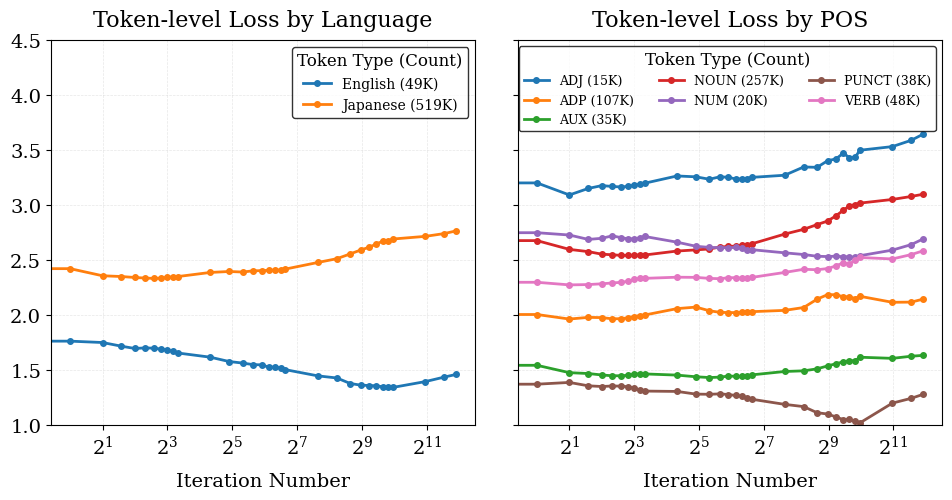

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Set global font and style for academic presentation
# plt.style.use('seaborn')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['grid.alpha'] = 0.3

# Define a professional color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# Helper function to build dataframe for a given type (pos/lang/ner)
def build_df(loss_inspections, category):
    records = []
    for iteration in loss_inspections:
        for key, losses in loss_inspections[iteration][category].items():
            avg_loss = sum(losses) / len(losses) if losses else 0.0
            count = len(losses)
            records.append({
                "iteration": iteration,
                "type": key,
                "avg_loss": avg_loss,
                "count": count,
            })

    df = pd.DataFrame(records)
    total_counts = df.groupby("type")["count"].mean().to_dict()
    for k in total_counts:
        total_counts[k] = str(int(total_counts[k]))[:-3] + "K"

    df["label"] = df["type"].apply(lambda l: f"{l} ({total_counts[l]})")
    pivot_df = df.pivot(index="iteration", columns="label", values="avg_loss")
    return pivot_df

# Build pivot tables for pos and lang
pivot_pos = build_df(loss_inspections, "pos")
pivot_lang = build_df(loss_inspections, "lang")

# Create figure with enhanced layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11.5, 5), sharey=True, gridspec_kw={'wspace': 0.1})
fig.tight_layout(pad=3.0)

# Language subplot
pivot_lang.plot(ax=ax1, linewidth=2, color=colors[:2], marker='o', markersize=4)
ax1.set_xlabel("Iteration Number", fontsize=14, labelpad=10)
ax1.set_title("Token-level Loss by Language", fontsize=16, pad=10)
ax1.set_xscale('log', base=2)
ax1.set_ylim(1, 4.5)
ax1.tick_params(labelsize=14)
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.legend(title="Token Type (Count)", title_fontsize=12, fontsize=10, frameon=True, edgecolor='black')

# POS subplot
pivot_pos.plot(ax=ax2, linewidth=2, color=colors, marker='o', markersize=4)
ax2.set_xlabel("Iteration Number", fontsize=14, labelpad=10)
ax2.set_ylabel("Cross-entropy Loss", fontsize=14, labelpad=10)
ax2.set_title("Token-level Loss by POS", fontsize=16, pad=10)
ax2.tick_params(labelsize=14)
ax2.set_xscale('log', base=2)
ax2.grid(True, linestyle='--', linewidth=0.5)
ax2.legend(title="Token Type (Count)", title_fontsize=12, fontsize=9, ncol=3, frameon=True, edgecolor='black')

# Adjust layout and save with high quality
result_dir = "../figures"
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
plt.savefig(
    os.path.join(result_dir, "token_loss_analysis.pdf"),
    dpi=300, bbox_inches="tight", facecolor='white'
)
# plt.close()

In [6]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Step 1: Helper function to build dataframe for a given type (pos/lang/ner)
# def build_df(loss_inspections, category):
#     records = []
#     for iteration in loss_inspections:
#         for key, losses in loss_inspections[iteration][category].items():
#             avg_loss = sum(losses) / len(losses) if losses else 0.0
#             count = len(losses)
#             records.append({
#                 "iteration": iteration,
#                 "type": key,
#                 "avg_loss": avg_loss,
#                 "count": count,
#             })

#     df = pd.DataFrame(records)
#     total_counts = df.groupby("type")["count"].mean().to_dict()
#     for k in total_counts:
#         total_counts[k] = str(int(total_counts[k]))[:-3] + "K"

#     df["label"] = df["type"].apply(lambda l: f"{l} ({total_counts[l]})")
#     pivot_df = df.pivot(index="iteration", columns="label", values="avg_loss")
#     return pivot_df

# # Step 2: Build pivot tables for pos, lang, ner
# pivot_pos = build_df(loss_inspections, "pos")
# pivot_lang = build_df(loss_inspections, "lang")
# pivot_ner = build_df(loss_inspections, "ner")

# # Step 3: Plot three subplots in one row with shared y-axis
# fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
# plt.subplots_adjust(wspace=0)

# # NER subplot
# # pivot_ner.plot(ax=axes[0], linewidth=2)
# # axes[0].set_xlabel("Iteration Number", fontsize=12)
# # axes[0].set_title("Token-level Loss by Named Entity", fontsize=14)
# # axes[0].set_xscale('log', base=2)
# # axes[0].tick_params(labelsize=12)
# # axes[0].set_ylim(1, 4.5)
# # axes[0].grid(True)
# # axes[0].legend(title="Token Type (Count)", fontsize=10, title_fontsize=10)

# # Lang subplot
# pivot_lang.plot(ax=axes[0], linewidth=2)
# axes[0].set_xlabel("Iteration Number", fontsize=12)
# axes[0].set_title("Token-level Loss by Language", fontsize=14)
# axes[0].set_xscale('log', base=2)
# axes[0].grid(True)
# axes[0].tick_params(labelsize=12)
# axes[0].set_ylim(1, 4.5)
# axes[0].legend(title="Token Type (Count)", fontsize=12, title_fontsize=12)

# # POS subplot
# pivot_pos.plot(ax=axes[1], linewidth=2)
# axes[1].set_xlabel("Iteration Number", fontsize=12)
# axes[1].set_ylabel("Cross-entropy Loss", fontsize=12)
# axes[1].set_title("Token-level Loss by POS", fontsize=14)
# axes[1].set_xscale('log', base=2)
# axes[1].grid(True)
# axes[1].tick_params(labelsize=12)
# axes[1].legend(title="Token Type (Count)", fontsize=8, 
#                title_fontsize=10, ncol=3, handlelength=1, handleheight=1)

# plt.tight_layout(pad=1.0, w_pad=0.2, h_pad=0.2)
# # plt.subplots_adjust(wspace=0.2)
# # plt.show()
# result_dir = "../figures"
# plt.savefig(
#     os.path.join(result_dir, f"token_loss_analysis.pdf"), 
#     dpi=300, bbox_inches="tight")



In [7]:
from tkinter import font
from turtle import title
import pandas as pd
import matplotlib.pyplot as plt
from pyparsing import line

# Step 1: Collect data into rows
records = []

for iteration in loss_inspections:
    for lang, losses in loss_inspections[iteration]["pos"].items():
        avg_loss = sum(losses) / len(losses) if losses else 0.0
        count = len(losses)
        records.append({
            "iteration": iteration,
            "lang": lang,
            "avg_loss": avg_loss,
            "count": count,
        })

# Step 2: Create DataFrame
df = pd.DataFrame(records)
total_counts = df.groupby("lang")["count"].mean().to_dict()
for key in total_counts:
    total_counts[key] = str(int(total_counts[key]))[:-3] + "K"
  
df["lang_label"] = df["lang"].apply(lambda l: f"{l} ({total_counts[l]})")

# Step 5: Pivot using lang_label
pivot_df = df.pivot(index="iteration", columns="lang_label", values="avg_loss")

# Step 6: Plot
plt.figure()
pivot_df.plot(figsize=(6, 3), linewidth=2)
plt.xlabel("Iteration Number", fontsize=12)
plt.ylabel("Cross-entropy Loss", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title("Token-level Loss by POS", fontsize=14)
plt.grid(True)
plt.xscale('log', base=2)
plt.legend(title="Token Type (Count)", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=12)
# plt.legend(title="Token Type (Count)", fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named '_tkinter'

In [ ]:
for iteration in loss_inspections:
    print(f"Iteration {iteration}:")
    for lang, losses in loss_inspections[iteration]["pos"].items():
        print(f"POS Type: {lang}, Average Loss: {sum(losses) / len(losses):.4f}, Count: {len(losses)}")

In [ ]:
for iteration in loss_inspections:
    print(f"Iteration {iteration}:")
    for lang, losses in loss_inspections[iteration]["ner"].items():
        print(f"Ner Type: {lang}, Average Loss: {sum(losses) / len(losses):.4f}, Count: {len(losses)}")

In [ ]:
for iteration in loss_inspections:
    print(f"Iteration {iteration}:")
    for lang, losses in loss_inspections[iteration]["ner"].items():
        print(f"Ner Type: {lang}, Average Loss: {sum(losses) / len(losses):.4f}, Count: {len(losses)}")

In [ ]:
for input in tqdm(inputs):
    for token in input['pos']:
        if token['type'] == 'INTJ':
            print(token)


In [ ]:
for lang, losses in lang_loss.items():
    print(f"Language: {lang}, Losses: {sum(losses)/len(losses)}, {len(losses)}")